In [1]:
import pandas as pd
import os
import torch 
import torch.nn as nn
import torchvision
import codecs
from collections import Counter,defaultdict
from nltk.corpus import stopwords
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import string
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch
from torch.autograd import Variable
from ast import literal_eval

In [2]:
raw_dataframe = pd.read_csv("../data/Labelled_tweets_v1.csv")
raw_dataframe.head()

,Tweet,UserHandle,Party,Issue,Stance
0,a no of people approach me daily worried abt t...,ArvindKejriwal,AAP,GST,Disagreement
1,its now revealed that our fms silence on the p...,ArvindKejriwal,AAP,PNB Scam,Neutral
2,pnb scam started in is going on till today the...,ArvindKejriwal,AAP,PNB Scam,Neutral
3,would bjp confirm this if true what transpired...,ArvindKejriwal,AAP,PNB Scam,Neutral
4,bjp insiders telling that niravmodi been a reg...,ArvindKejriwal,AAP,PNB Scam,Neutral


In [3]:
# Get index on classes
stance_df = raw_dataframe.Stance
stances = np.unique(stance_df)
print(stances)
stance_idx = {}
for i in range(len(stances)):
    stance_idx[stances[i]] = i
print(stance_idx)
raw_dataframe.Stance.replace(to_replace = stance_idx, inplace = True)

issue_df = raw_dataframe['Issue']
issues = np.unique(issue_df)
print(issues)
issue_idx = {}
for i in range(len(issues)):
    issue_idx[issues[i]] = i
print(issue_idx)
raw_dataframe.Issue.replace(to_replace=issue_idx, inplace=True)
raw_dataframe.head(10)

['Agreement' 'Disagreement' 'Neutral']
{'Neutral': 2, 'Agreement': 0, 'Disagreement': 1}
['Aadhar linking' 'Beef Ban' 'Cauvery SC Verdict' 'Demonetisation'
 'EVM tampering' 'FDIPolicy' 'Fodder scam' 'GDP growth' 'GST'
 'Inflation control' 'Jallikattu ban' 'PNB Scam'
 'Padmavati film screening' 'Ram Mandir' 'RightToPrivacy SC Verdict'
 'Rohingyas' 'Swacch Bharat' 'Triple Talaq SC verdict' 'TripleTalaqBill'
 'acchedin' 'hike in oil prices' 'lgp price hike' 'nsc and ppf rate cuts'
 'reservation']
{'acchedin': 19, 'Jallikattu ban': 10, 'Fodder scam': 6, 'Cauvery SC Verdict': 2, 'PNB Scam': 11, 'Swacch Bharat': 16, 'FDIPolicy': 5, 'RightToPrivacy SC Verdict': 14, 'Padmavati film screening': 12, 'EVM tampering': 4, 'hike in oil prices': 20, 'Aadhar linking': 0, 'lgp price hike': 21, 'GST': 8, 'Beef Ban': 1, 'GDP growth': 7, 'Triple Talaq SC verdict': 17, 'Ram Mandir': 13, 'Rohingyas': 15, 'nsc and ppf rate cuts': 22, 'TripleTalaqBill': 18, 'reservation': 23, 'Inflation control': 9, 'Demoneti

,Tweet,UserHandle,Party,Issue,Stance
0,a no of people approach me daily worried abt t...,ArvindKejriwal,AAP,8,1
1,its now revealed that our fms silence on the p...,ArvindKejriwal,AAP,11,2
2,pnb scam started in is going on till today the...,ArvindKejriwal,AAP,11,2
3,would bjp confirm this if true what transpired...,ArvindKejriwal,AAP,11,2
4,bjp insiders telling that niravmodi been a reg...,ArvindKejriwal,AAP,11,2
5,is it possible to believe that he or vijay mal...,ArvindKejriwal,AAP,11,2
6,someone told me today sealing bjp wants to rui...,ArvindKejriwal,AAP,5,2
7,if all state govts central govt and sc togethe...,ArvindKejriwal,AAP,5,2
8,three killings on merchants in one year first ...,ArvindKejriwal,AAP,8,1
9,there is no need to increase house tax in mcd ...,ArvindKejriwal,AAP,8,1


In [4]:
# Remove selected stopwords from the dataset
stop_words = ['the','of','in','and','a','is','on','this','all','it','will','for','to','be','with',
              'at','are','u','has','that','by','from', 'as','was','have','its','an','if','been','be','also','should','which']
for count, row in raw_dataframe.iterrows():
    tweet = row['Tweet']
    new_tweet = []
    for word in tweet.split():
        if word not in stop_words:
            new_tweet.append(word)
    raw_dataframe.iloc[count, 0] = ' '.join(new_tweet)

In [24]:
PADDING_IDX = 1
class Net(nn.Module):
    def __init__(self, vocab_size, hidden_size, input_size):
        super(Net,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size_label = 3
        self.word_embeddings = nn.Embedding(vocab_size, self.input_size, padding_idx=PADDING_IDX)
        self.GRU = nn.GRU(self.input_size, self.hidden_size,num_layers = 1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, 3)
        
        self.linear_label = nn.Linear(self.hidden_size, hidden_size)
        self.out_label = nn.Linear(self.hidden_size,self.output_size_label)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,x_input,hidden_state):
        embedded = self.word_embeddings(x_input)
        #print(embedded.shape)
        #output = embedded.view(-1,-1, self.hidden_size)
        output, hn = self.GRU(embedded)
        #hn_ = hn[0].reshape(x_input.shape[0],output.shape[1]*output.shape[2])
        #print(output.shape)
        #linear = self.linear(hn)
        #print(linear.shape)
        output_2 = self.linear_label(hn[0])
        output_2 = F.relu(output_2)
        output_2 = self.out_label(output_2)
        output_2 = self.softmax(output_2)
        
        return output_2

    def H_t0(self, batch_size):
        return torch.zeros(1,batch_size,self.hidden_size)

In [6]:
# accuracies = []
# for issue, idx in issue_idx.items():
#     print('Leaving out issue: {0}, idx: {1}'.format(issue, idx))
#     train_data = raw_dataframe[raw_dataframe.Issue != idx]
#     test_data = raw_dataframe[raw_dataframe.Issue == idx]
    
#     print('Splitting dataset based on issue')
#     X_train = train_data['Tweet'].values
# #     Y1_train = train_data['Issue'].values
#     Y2_train = train_data['Stance'].values
#     print(X_train.shape, Y1_train.shape, Y2_train.shape)
    
#     X_test = test_data['Tweet'].values
# #     Y1_test = test_data['Issue'].values
#     Y2_test = test_data['Stance'].values
#     print(X_test.shape, Y1_test.shape, Y2_test.shape)
    
#     print('Generating tf-idf vectors')
#     # Get tfidf vectors for train, val and test
#     tfidf_vec = TfidfVectorizer()
#     X_train_tf = tfidf_vec.fit_transform(X_train).toarray()
#     print(X_train_tf.shape)
    
#     X_test_tf = tfidf_vec.transform(X_test).toarray()
#     print(X_test_tf.shape)
    
#     # Classify using Logistic regression
#     from sklearn.linear_model import LogisticRegression

#     log2 = LogisticRegression()
#     y2_pred = log2.fit(X_train_tf, Y2_train).predict(X_test_tf)

#     print('Stance classification')
#     acc = accuracy_score(Y2_test, y2_pred)
#     accuracies.append(acc)
#     print('Accuracy: ', acc)
# #     print('Weighted F1 score: ', f1_score(Y2_test, y2_pred, averag÷e='weighted'))
# accuracies = np.array(accuracies)
# print('Avg accuracy: ', np.mean(accuracies))

In [7]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
            
    def getSentIdx(self, sentence):
        idx = []
        for word in sentence.split(' '):
            idx.append(self.word2index.get(word, 1))
        return idx
            
raw_dataframe['Tweet_idx'] = 0
voc = Voc('stance')     
for count, row in raw_dataframe.iterrows():
    tweet = row['Tweet']
    voc.addSentence(tweet)
    raw_dataframe.iloc[count, 5] = str(voc.getSentIdx(tweet))
    
voc_len = len(voc.word2index) + 100
print('Vocab length: ', voc_len)
raw_dataframe.to_csv('../Dataset/Dataset_with_vocidx.csv', index = False)

Vocab length:  17539


In [8]:
WORDS_PER_DOC = 60
PADDING_IDX = 1
class StanceDataset(Dataset):
    
    def __init__(self, df):
        super(StanceDataset, self).__init__()
        self.ds = df
    
    def __getitem__(self, idx):
        content = self.ds.iloc[idx, 5]
        content = literal_eval(content)
        if len(content) >= WORDS_PER_DOC:
            content = np.array(content[:WORDS_PER_DOC])
        else:
            content = np.pad(content, (0, WORDS_PER_DOC-len(content)), 'constant', constant_values=(0, PADDING_IDX))
        label = int(self.ds.iloc[idx, 4])
#         print(content)
        return torch.from_numpy(content), label
    
    def __len__(self):
        return self.ds.shape[0]

In [60]:
def eval(loader, net):
    running_loss = 0
    num_batches = 0
    total = 0
    correct = 0
    gt = []
    f1_scores = []
    predicteds = []
    for i, data in enumerate(loader, 0):
        # get the inputs
        batch_x, batch_y = data
#             print(batch_x)
        batch_x = Variable(torch.LongTensor(batch_x))
        batch_y = Variable(torch.LongTensor(batch_y))
        batch_y = batch_y.reshape(batch_y.shape[0])
        encoder_hidden = Variable(net.H_t0(batch_y.shape[0]))
        output = net(batch_x,encoder_hidden)
        #print(output.shape)
        _, predicted = torch.max(output.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y.data).sum()
        num_batches += 1
#         print(predicted)
#         print(batch_y)
        f1_scores.append(f1_score(np.array(predicted),np.array(batch_y),average='micro'))
        for g in batch_y:
            gt.append(g.tolist())
        for p in predicted:
            predicteds.append(p.tolist())
            
#     print(predicteds)
    acc = 100*correct/total
    f1_avg = sum(f1_scores)/len(f1_scores)
    
    return acc,predicteds,f1_avg, gt

In [58]:
f1_scores_all = defaultdict(list)
predicted_all = defaultdict(list)
gt_all = defaultdict(list)
acc_all = defaultdict(list)

Leaving out issue: acchedin, idx: 19


/home/bedanta/ml/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/bedanta/ml/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


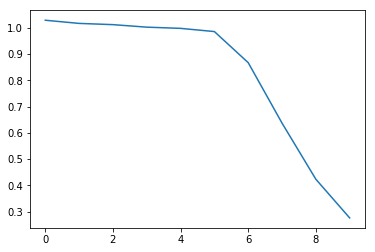

Accuracy:  tensor(54)
Leaving out issue: Jallikattu ban, idx: 10


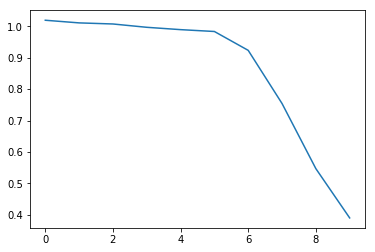

Accuracy:  tensor(30)
Leaving out issue: Fodder scam, idx: 6


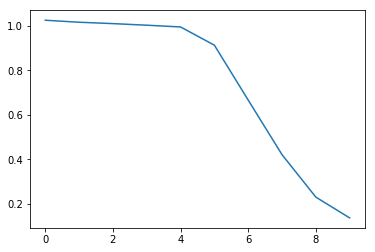

Accuracy:  tensor(54)
Leaving out issue: Cauvery SC Verdict, idx: 2


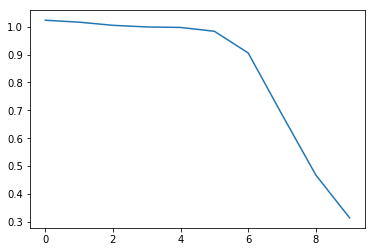

Accuracy:  tensor(33)
Leaving out issue: PNB Scam, idx: 11


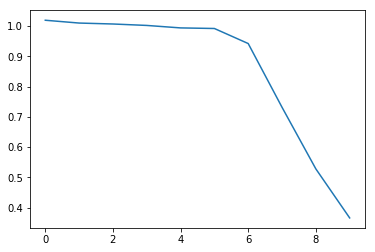

Accuracy:  tensor(51)
Leaving out issue: Swacch Bharat, idx: 16


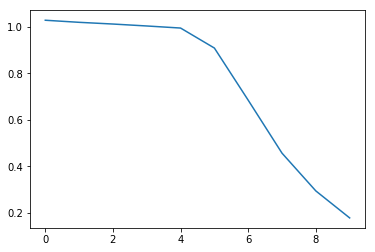

Accuracy:  tensor(53)
Leaving out issue: FDIPolicy, idx: 5


In [ ]:
accuracies = []
f1_scores =[]
for issue, idx in issue_idx.items():
    print('Leaving out issue: {0}, idx: {1}'.format(issue, idx))
    train_data = raw_dataframe[raw_dataframe.Issue != idx]
    test_data = raw_dataframe[raw_dataframe.Issue == idx]
    
    train_ds = StanceDataset(train_data)
    test_ds = StanceDataset(test_data)
    
    # Create loader instances
    batch_size = 32
    train_loader = DataLoader(dataset = train_ds, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(dataset = test_ds, batch_size = batch_size, shuffle = False)
    
    net = Net(voc_len, 256, 100)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
    epochs = 10
    epoch_losses = []
    for e in range(epochs):
        batch = 0
        epoch_loss = 0
        running_loss = 0
        for i, data in enumerate(train_loader, 0):
            batch+=1
            optimizer.zero_grad()
            batch_x, batch_y = data
#             print(batch_x)
            batch_x = Variable(torch.LongTensor(batch_x))
            batch_y = Variable(torch.LongTensor(batch_y))
            batch_y = batch_y.reshape(batch_y.shape[0])
            encoder_hidden = Variable(net.H_t0(batch_y.shape[0]))
            output = net(batch_x,encoder_hidden)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data[0]
            running_loss += loss.data[0]
#             if batch%30==0:
#                 epoch_losses.append(running_loss/30)
#                 running_loss = 0
            
        epoch_loss /= len(train_data)/batch_size
#         print(epoch_loss)
        epoch_losses.append(epoch_loss)
#     encoder_hidden_test = Variable(net.H_t0(len(x_tweet_test)))
#     predicted_output = net(x_tweet_test,encoder_hidden_test)
#     predicted_output = predicted_output.reshape(len(x_tweet_test),3)
#     predicted_output = predicted_output.detach().numpy()
#     predicted_output = np.argmax(predicted_output,axis = 1)
#     predicted_list[one] = predicted_output
#     ground_truth[one] = y_label_test
#     accuracy = accuracy_score(predicted_output,y_label_test)
#     print(accuracy)
    plt.plot(epoch_losses)
    plt.show()
#     epoch_loss_all_issues[one] = epoch_losses
    acc,pred,f1,gt = eval(test_loader, net)
    acc_all[issue] = float(acc)
    predicted_all[issue] = pred
    f1_scores_all[issue] = f1
    gt_all[issue]=gt
    print('Accuracy: ', acc)

In [ ]:
print(np.mean(np.array(list(acc_all.values()))))
np.mean(np.array(list(f1_scores_all.values())))

In [52]:
_,pred = torch.max(output,1)

In [53]:
_

tensor([-0.7606, -0.7606, -0.7606, -0.7606], grad_fn=<MaxBackward0>)

In [48]:
output

tensor([[-0.7606, -1.0054, -1.7915],
        [-0.7606, -1.0054, -1.7915],
        [-0.7606, -1.0054, -1.7915],
        [-0.7606, -1.0054, -1.7915]], grad_fn=<LogSoftmaxBackward>)

In [ ]:
rnn = nn.GRU(10, 20, 1, batch_first=True)
input = torch.randn(32, 14000, 10)
h0 = torch.randn(1, 3, 20)


In [ ]:
print('Processing output')
output, hn = rnn(input, h0)